# Task 3. Algorithms for unconstrained nonlinear optimization. First- and second-order methods

## Samarin Anton, C4113

### December 7, 2019

In [59]:
import numpy as np
import math
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from scipy import optimize
from functools import partial
from functools import wraps
from collections import namedtuple
from typing import Tuple
import warnings

warnings.filterwarnings('ignore')

In [60]:
# for more beauty image
%matplotlib notebook

plt.rcParams['figure.figsize'] = [6, 5]

## Helpers

In [61]:
def middleware(params, func):
    '''Format data as list'''
    return error(func, params[0], params[1])

In [62]:
def plot_functional(func, title):
    '''Show functional'''
    a_possible = np.arange(-0.5, 2, 0.01)
    b_possible = np.arange(-0.5, 2, 0.01)
    A, B = np.meshgrid(a_possible, b_possible)
    Z = np.zeros((len(b_possible), len(a_possible)))
    for i in range(len(b_possible)):
        for j in range(len(a_possible)):
            Z[i][j] = error(func, a_possible[j], b_possible[i])
    
    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(A, B, Z, cmap=cm.coolwarm)
    ax.set_title(title, {'fontsize': 25}, pad=25)
    ax.set_xlabel('a', {'fontsize': 15})
    ax.set_ylabel('b', {'fontsize': 15})
    ax.set_zlabel('Error', {'fontsize': 15})
    fig.show()

In [63]:
def plot_lines_lvl(func, title, data, max_val=1000, step=50):
    '''Show lines of levels'''
    a_possible = np.arange(-0.5, 2, 0.01)
    b_possible = np.arange(-0.5, 2, 0.01)
    A, B = np.meshgrid(a_possible, b_possible)
    Z = np.zeros((len(b_possible), len(a_possible)))
    for i in range(len(b_possible)):
        for j in range(len(a_possible)):
            Z[i][j] = error(func, a_possible[j], b_possible[i])
    
    levels = [i for i in range(0, max_val, step)]
    plt.contour(A, B, Z, levels, colors='k')
    contour_filled = plt.contourf(A, B, Z, levels, cmap="RdBu_r")
    plt.colorbar(contour_filled)
    
    plt.title(title, {'fontsize': 20}, pad=25)
    plt.xlabel('a', {'fontsize': 15})
    plt.ylabel('b', {'fontsize': 15})
    
    plt.plot(data[0], data[1], color='red', label = 'way to minimum')
    plt.scatter(data[0],data[1], s=30, color='red', edgecolors='black')
    
    plt.legend(loc='best')
    plt.show()

In [64]:
DELTA = np.sqrt(np.finfo(float).eps)  # Config delta (for computing error)

In [65]:
def jacobian(params: Tuple[float, float], func):
    return optimize.approx_fprime(params, func, (DELTA, DELTA))

In [66]:
def hessian(params: Tuple[float, float], func):
    current_jac = partial(jacobian, func=func)
    
    diff_func_a = lambda point: current_jac(point)[0]
    diff_func_b = lambda point: current_jac(point)[1]
    
    return (optimize.approx_fprime(params, diff_func_a, (100 * DELTA, 100 * DELTA)),
           optimize.approx_fprime(params, diff_func_b, (100 * DELTA, 100 * DELTA)))

In [67]:
def points_to_vectors(points):
    '''Convert from list of points to pair of lists coordinates'''
    return [[i for i, _ in points], [j for _, j in points]] 

In [68]:
def printable(func):
    '''Decorator for printing information of computing'''
    
    @wraps(func)
    def wrapper(*args, **kwargs):
        result, nfev, njev, iters, path, nhev = func(*args, **kwargs)
        print(f'Minimum argument obtained from {func.__name__}:', result)
        print(f'Number of call {func.__name__}:', nfev)
        print(f'Number of computing of jacobian {func.__name__}:', njev)
        print(f'Number of iterations {func.__name__}:', iters) if iters else None
        print(f'Number of computing of hessian {func.__name__}:', nhev) if nhev else None
        
        return result, path

    return wrapper

In [69]:
def plot_regression(grd, cng_grd, newton, lma, title):
    '''Show generated data and regression'''
    args = np.array([0, 1])
    
    plt.scatter(x, y, s=30, color='blue', alpha = 0.3)
    
    plt.plot(args, grd.a * args + grd.b, color='red', label='Gradient method')
    plt.plot(args, cng_grd.a * args + cng_grd.b, color='green', label='Conjugate Gradient')
    plt.plot(args, newton.a * args + newton.b, color='magenta', label='Newton’s method')
    plt.plot(args, lma.a * args + lma.b, color='yellow', label='Levenberg-Marquardt algorithm (LMA)')
    
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(title, {'fontsize': 20}, pad=20)
    plt.legend(loc='best')
    plt.grid()
    plt.show()

In [70]:
Point = namedtuple('Point', ['a', 'b'])

## Generate data

In [71]:
EPS = 0.001

In [72]:
SUPPOSE_MIN = np.random.uniform(-0.5, 1.5, 2)
print(f'Start optimisation {SUPPOSE_MIN}')

Start optimisation [-0.13524042  1.39377138]


In [77]:
# source coefficients
a, b = np.random.uniform(0, 1, 2)
k = 1000
print(f'a = {a}', f'b = {b}', sep='\n')

a = 0.132763247307649
b = 0.3940935880488272


In [78]:
# generate noisy data
x = np.arange(0, 1 + 1 / k, 1 / k)
d = np.random.normal(0, 1, k + 1)
y = a * x + b + d

<IPython.core.display.Javascript object>


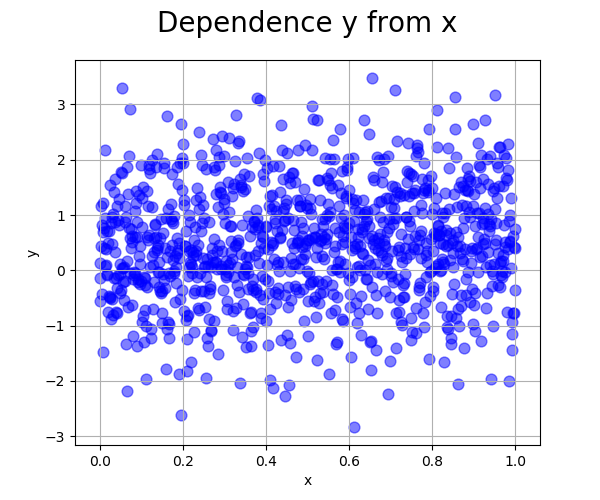

In [79]:
# show data
plt.scatter(x, y, s=60, color='blue', alpha = 0.5)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Dependence y from x', {'fontsize': 20}, pad=20)
plt.grid()
plt.show()

## Regressions

In [80]:
def error(func, a, b):
    """function of errors"""
    return np.sum((func(a, b) - y) ** 2)

In [81]:
def linear(a, b):
    return a * x + b

In [82]:
def rational(a, b):
    return a / (1 + b * x)

<IPython.core.display.Javascript object>


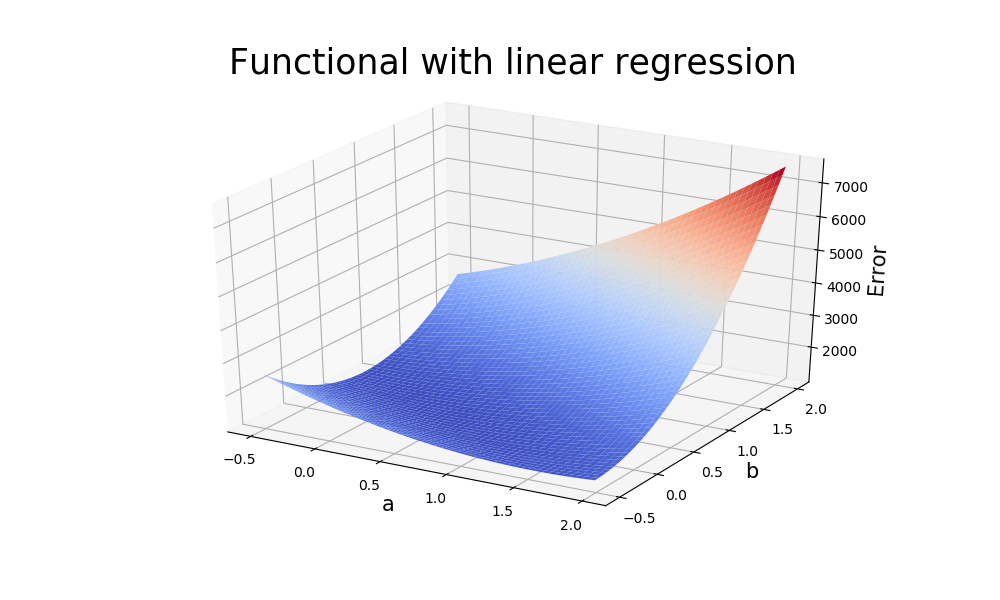

In [83]:
plot_functional(linear, 'Functional with linear regression')

<IPython.core.display.Javascript object>


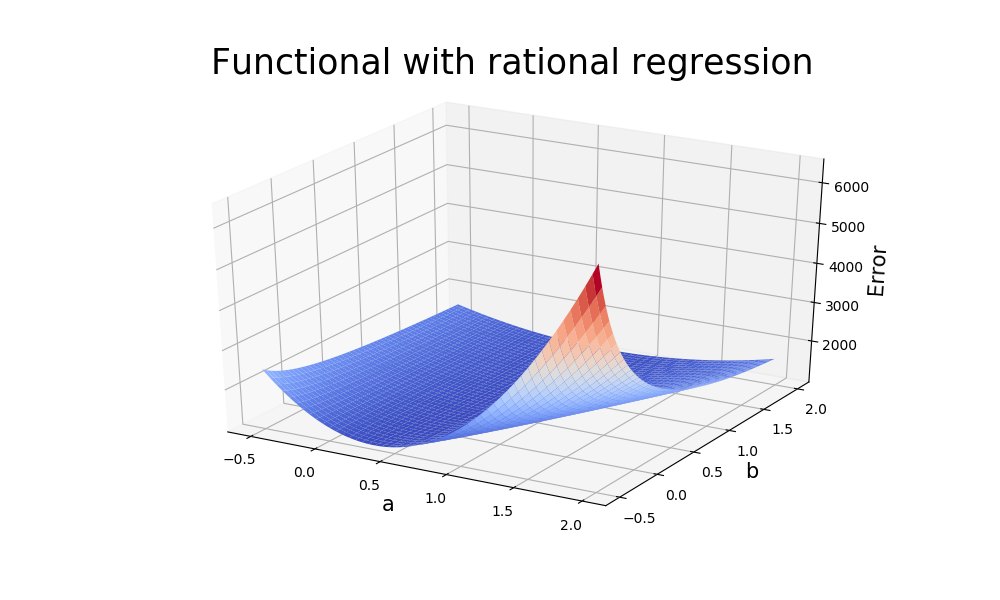

In [84]:
plot_functional(rational, 'Functional with rational regression')

## Optimization methods

### Conjugate Gradient

In [85]:
@printable
def conjugate_gradient_method(func):
    error_func = partial(middleware, func=func)
    current_jac = partial(jacobian, func=error_func)
    
    result = optimize.minimize(error_func, method='CG', x0=SUPPOSE_MIN, jac=current_jac,
                               options={'gtol': EPS, 'return_all': True})
    
    return result.x, result.nfev, result.njev, result.nit, result.allvecs, None

### Newton’s method

In [86]:
@printable
def newton_method(func):
    error_func = partial(middleware, func=func)
    current_jac = partial(jacobian, func=error_func)
    current_hess = partial(hessian, func=error_func)
    
    result = optimize.minimize(error_func, method='Newton-CG', jac=current_jac, hess=current_hess, x0=SUPPOSE_MIN,
                              options={'xtol': EPS, 'return_all': True})
    
    return result.x, result.nfev, result.njev, result.nit, result.allvecs, result.nhev

### Levenberg-Marquardt algorithm (LMA)

In [87]:
@printable
def levenberg_marquard_algorithm(func):
    error_func = partial(middleware, func=func)
    current_jac = partial(jacobian, func=error_func)
    
    def two_demention_func(point, func, const):
        return func(point), const
    
    full_error_func = partial(two_demention_func, func=error_func, const=0)
    full_jac = partial(two_demention_func, func=current_jac, const=(0, 0))
    
    # least_squares get function: R^N -> R^N
    result = optimize.least_squares(full_error_func, x0=SUPPOSE_MIN, method='lm', jac=full_jac, gtol=EPS)
    
    return result.x, result.nfev, result.njev, None, None, None

### Gradient method

In [88]:
@printable
def gradient_method(func):
    error_func = partial(middleware, func=func)
    current_jac = partial(jacobian, func=error_func)
    
    diff = np.array([np.inf, np.inf])
    jacb_point = np.array([np.inf, np.inf])
    
    current_min = SUPPOSE_MIN
    
    cnt = 0
    path = [SUPPOSE_MIN]
    nfev = 0
    njev = 0
    
    while np.linalg.norm(jacb_point) >= EPS and np.linalg.norm(diff) >= EPS and cnt <= 300:
        jacb_point = current_jac(current_min)
        optimal = lambda alpha: error_func(current_min - alpha * jacb_point)  # not unimodal function
        alpha, cnt_call = exhaustive_search(optimal)
        
        prev_min = np.array(current_min)
        current_min = current_min - alpha * jacb_point
        diff = current_min - prev_min
        
        path.append(current_min)
        cnt +=1
        njev += 1
        nfev += cnt_call
    
    return current_min, nfev, njev, cnt, path, None

In [89]:
def exhaustive_search(func, a=0, b=0.01, eps=EPS * 0.01):
    x_min = a
    f_min = np.inf
    
    cnt = 0
    
    for x in np.arange(a, b + eps, eps):
        current = func(x)
        cnt += 1
        if current < f_min:
            f_min = current
            x_min = x
    
    return x_min, cnt

## Functional with linear regression

Minimum argument obtained from gradient_method: [0.314044   0.31983948]
Number of call gradient_method: 17017
Number of computing of jacobian gradient_method: 17
Number of iterations gradient_method: 17


<IPython.core.display.Javascript object>


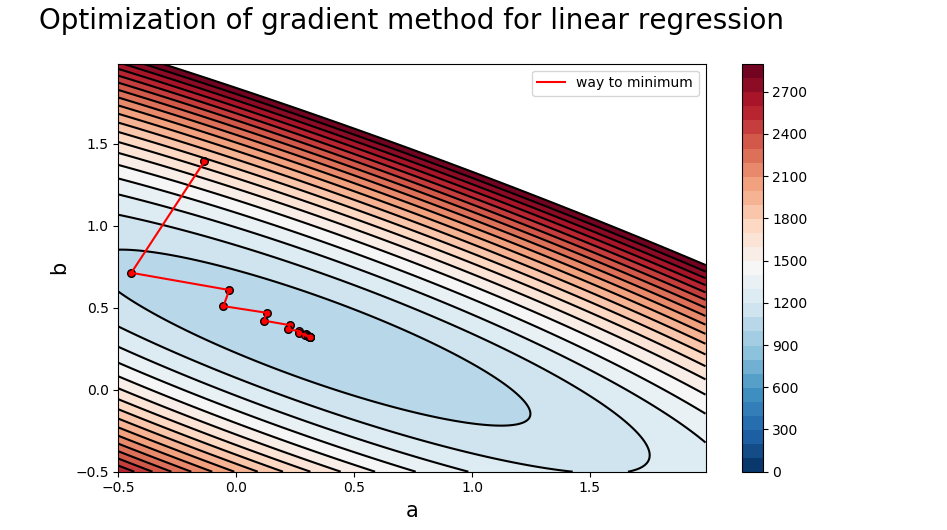

In [95]:
result, path = gradient_method(linear)
grd_linear = Point(*result)
plot_lines_lvl(linear, "Optimization of gradient method for linear regression", points_to_vectors(path), 3000, 100)

Minimum argument obtained from conjugate_gradient_method: [0.31765939 0.31796434]
Number of call conjugate_gradient_method: 6
Number of computing of jacobian conjugate_gradient_method: 6
Number of iterations conjugate_gradient_method: 2


<IPython.core.display.Javascript object>


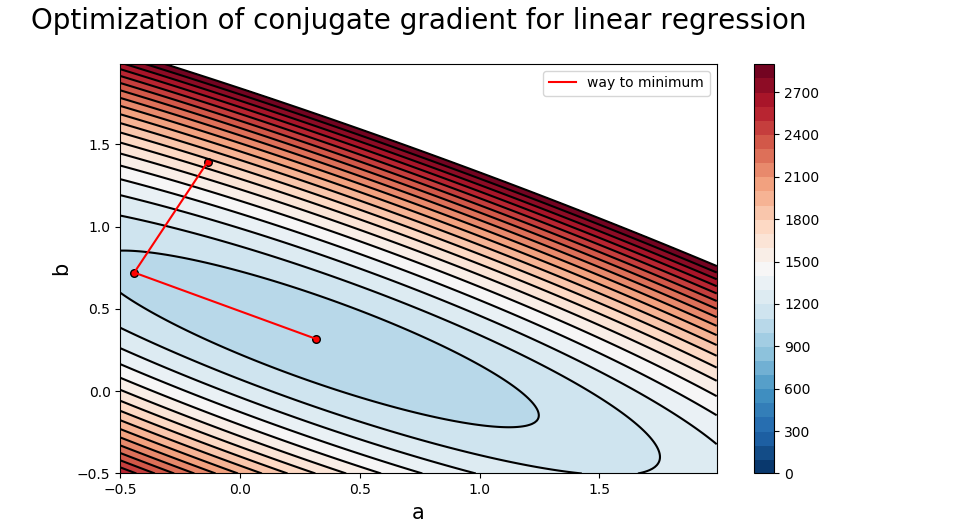

In [96]:
result, path = conjugate_gradient_method(linear)
cng_grd_linear = Point(*result)
plot_lines_lvl(linear, 'Optimization of conjugate gradient for linear regression', points_to_vectors(path), 3000, 100)

Minimum argument obtained from newton_method: [0.31754698 0.31802367]
Number of call newton_method: 6
Number of computing of jacobian newton_method: 10
Number of iterations newton_method: 5
Number of computing of hessian newton_method: 5


<IPython.core.display.Javascript object>


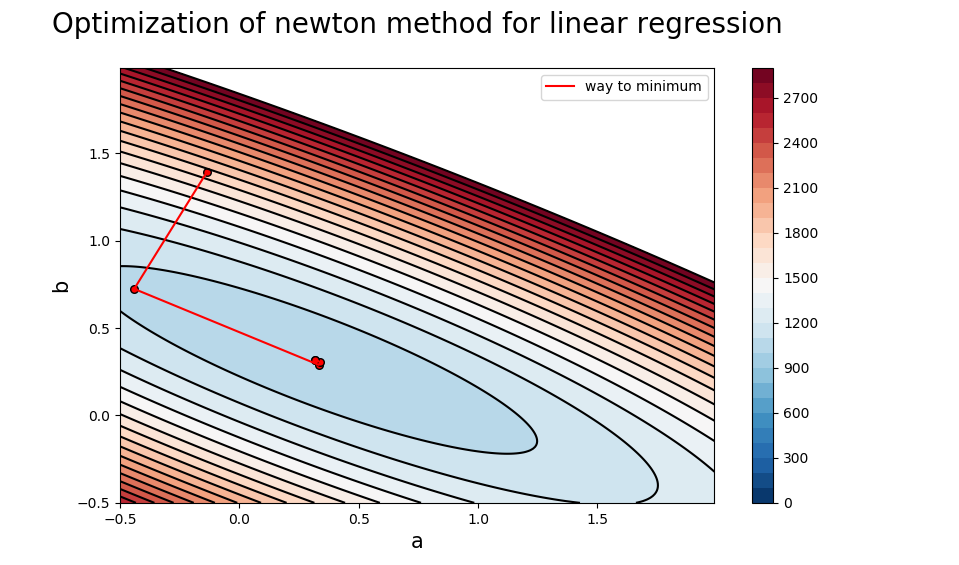

In [97]:
result, path = newton_method(linear)
newton_linear = Point(*result)
plot_lines_lvl(linear, 'Optimization of newton method for linear regression', points_to_vectors(path), 3000, 100)

In [98]:
result, path = levenberg_marquard_algorithm(linear)
lma_linear = Point(*result)

Minimum argument obtained from levenberg_marquard_algorithm: [0.31725446 0.31818541]
Number of call levenberg_marquard_algorithm: 62
Number of computing of jacobian levenberg_marquard_algorithm: 53


<IPython.core.display.Javascript object>


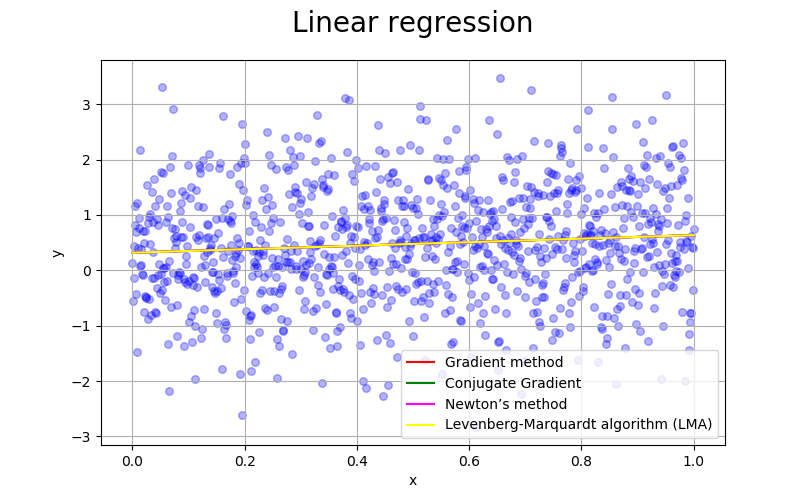

In [99]:
plot_regression(grd=grd_linear, cng_grd=cng_grd_linear, newton=newton_linear, lma=lma_linear, title='Linear regression')

<IPython.core.display.Javascript object>


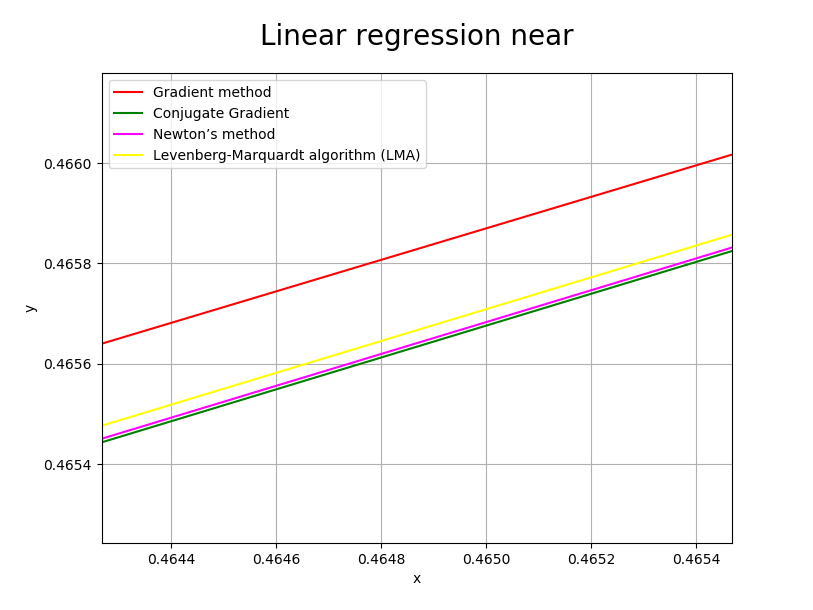

In [100]:
plot_regression(grd=grd_linear, cng_grd=cng_grd_linear, newton=newton_linear, lma=lma_linear,
                title='Linear regression near')

## Functional with rational regression

Minimum argument obtained from gradient_method: [ 0.36289934 -0.44043005]
Number of call gradient_method: 68068
Number of computing of jacobian gradient_method: 68
Number of iterations gradient_method: 68


<IPython.core.display.Javascript object>


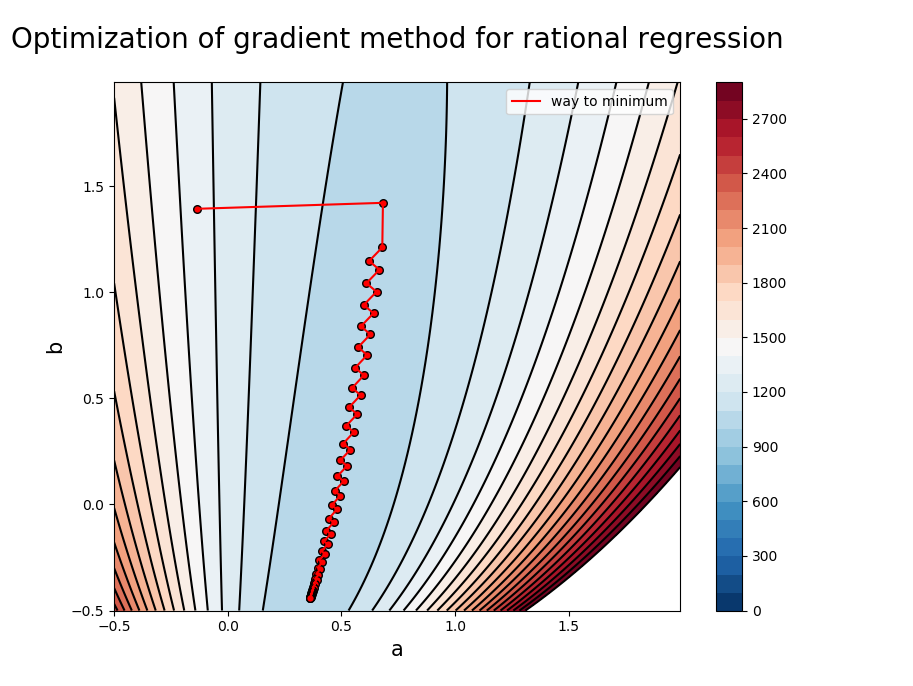

In [101]:
result, path = gradient_method(rational)
grd_rational = Point(*result)
plot_lines_lvl(rational, 'Optimization of gradient method for rational regression', points_to_vectors(path), 3000, 100)

Minimum argument obtained from conjugate_gradient_method: [ 0.35975571 -0.44924515]
Number of call conjugate_gradient_method: 38
Number of computing of jacobian conjugate_gradient_method: 38
Number of iterations conjugate_gradient_method: 11


<IPython.core.display.Javascript object>


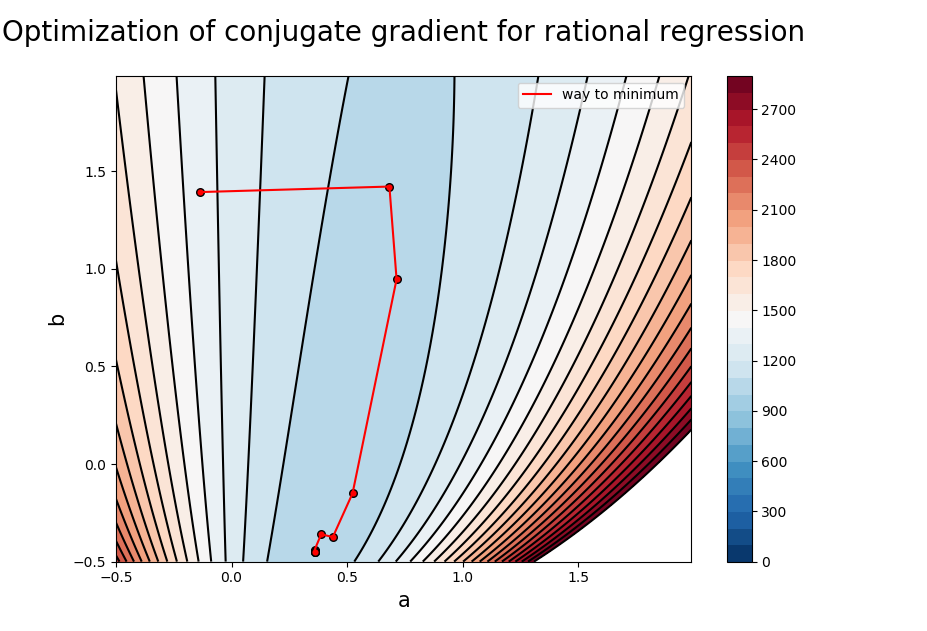

In [102]:
result, path = conjugate_gradient_method(rational)
cng_grd_rational = Point(*result)
plot_lines_lvl(rational, 'Optimization of conjugate gradient for rational regression', points_to_vectors(path), 3000, 100)

Minimum argument obtained from newton_method: [ 0.35975811 -0.44923903]
Number of call newton_method: 19
Number of computing of jacobian newton_method: 29
Number of iterations newton_method: 11
Number of computing of hessian newton_method: 11


<IPython.core.display.Javascript object>


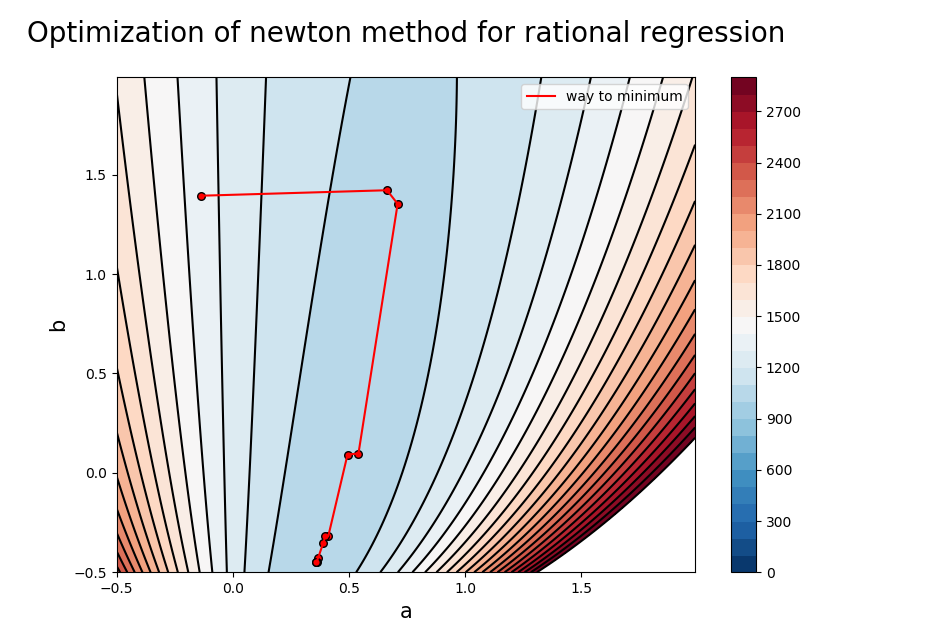

In [103]:
result, path = newton_method(rational)
newton_rational = Point(*result)
plot_lines_lvl(rational, 'Optimization of newton method for rational regression',points_to_vectors(path), 3000, 100)

In [104]:
result, path = levenberg_marquard_algorithm(rational)
lma_rational = Point(*result)

Minimum argument obtained from levenberg_marquard_algorithm: [ 0.35988894 -0.4488469 ]
Number of call levenberg_marquard_algorithm: 132
Number of computing of jacobian levenberg_marquard_algorithm: 116


<IPython.core.display.Javascript object>


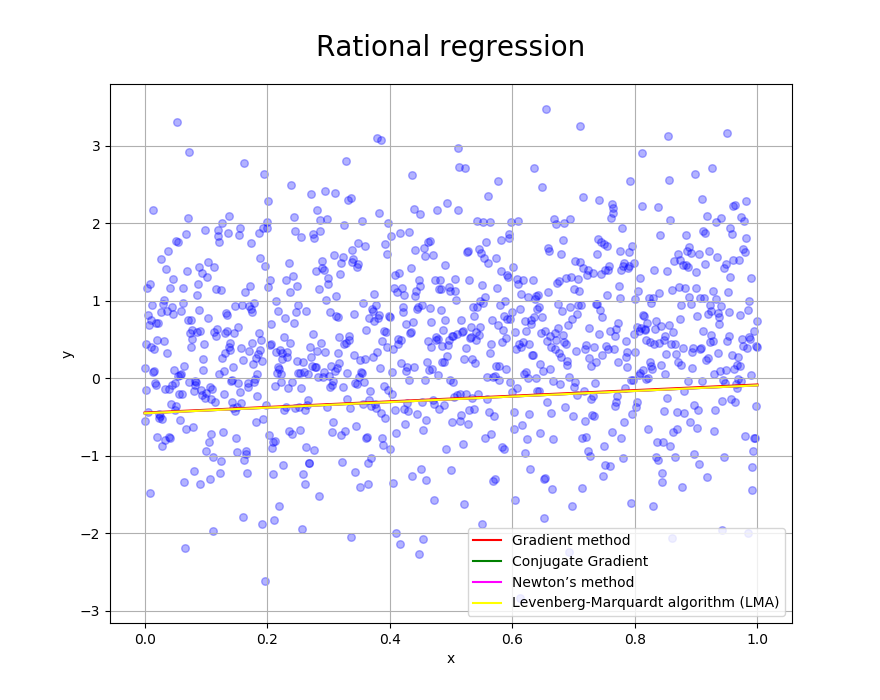

In [105]:
plot_regression(grd=grd_rational, cng_grd=cng_grd_rational, newton=newton_rational,
                lma=lma_rational, title='Rational regression')

<IPython.core.display.Javascript object>


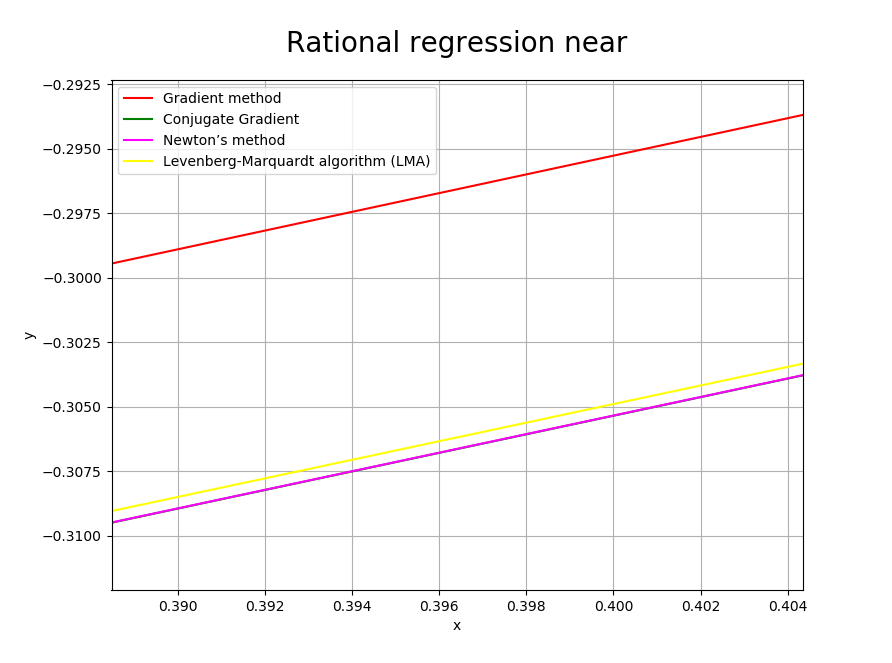

In [107]:
plot_regression(grd=grd_rational, cng_grd=cng_grd_rational, newton=newton_rational,
                lma=lma_rational, title='Rational regression near')

## Conclusion

* Gradient method is simpler than other in this task. But it has some problems. Function of optimization for choicen the best alpha is not unimodal, so gradient method can be diverging easy. In this case we choice brutte search for optimal alpha, because it work for anything function, but so we have a lot of calls functions. Also if method get into plateau that it converge slow.

* Conjugate Gradient method is the best in our experiment. It has few iterations than other algorithms. Computing  of Jacobian is enough for this method. Also it is work good on plateau.

* Newton’s method is second in our tops. Result is very similar on Conjugate Gradient method if we look at to graphics of regressions. It has less calls of function and jacobian for rational regression, but the main problem is computing of hessian. It is expensive operation, so there is Quasi-Newton method, that use approximate hessian. We use this in our task (scipy library).

* LMA specialize on least-squares curve fitting problem, that is in out task. We use algorithm from scipy, so problems can be in library. Library don't give information about number of iterations and interface is very strage (necessary $F: R^n -> R^n$). Number of calls function and computing of jacobian are more than in other methods. But it don't use hessian and result is close to results of Newton’s method and Conjugate Gradient method.